In [122]:
%matplotlib inline

import collections
import matplotlib.mlab as mlab
import csv
import pandas as pd
import numpy as np
import scipy as sp
from cvxpy import *
import matplotlib.pyplot as plt
import os
import copy

# Don't really need a class implementation, maybe useful later
class species(object):
    def __init__(self, Nres, strat_dist, lin, strat_p=0.1):
        if strat_dist == 'uniform':
            self.strategy = [np.random.uniform() for i in range(Nres)]
        elif strat_dist == 'binomial':
            self.strategy = np.random.choice([0, 1], size=(Nres), p=[1-strat_p, strat_p])
        else:
            print 'Incorrectly specified distribution: options include "uniform" and "binomial".'
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        self.fitness = np.exp(np.random.normal(0, 0.0001))
        self.norm_fit = self.fitness
        self.cost = 1
        self.lineage = lin
        self.barcode = [lin]
        self.frequency = []
    
    def perturb_fitness(self, epsilon):
        self.fitness = self.fitness*np.exp(np.random.normal(0, epsilon))
        return
    
    def normalize_fitness(self, av_fit):
        self.norm_fit = self.fitness/av_fit
        return
    
    def perturb_strategy(self, n=1):
        idx = np.random.choice(range(len(self.strategy)))
        self.strategy[idx] = 1-self.strategy[idx]
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        return
    
    def perturb_strat_dir(self, idx):
        self.strategy[idx] = 1-self.strategy[idx]
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        return
    
    def perturb_strategy_cont(self, epsilon):
        self.strategy = self.strategy+[epsilon*np.random.normal() for i in range(Nres)]
        self.strategy = self.strategy/np.sum(self.strategy)
        return
    
    def rebarcode(self, new_barcode):
        self.barcode.append(new_barcode)
        return
    
    def refrequency(self, frequency):
        self.frequency.append(frequency)
        return

#
#
#
# Helper functions
#
#
#

# Run optimization scheme        
def run_opt(vspecies, vres):
    
    Nspec = len(vspecies)
    Nres = len(vres)
    
    A = np.array([vspecies[i].norm_fit*vspecies[i].strat_norm for i in range(Nspec)])
    b = np.array([vspecies[i].cost for i in range(Nspec)])
    h = Variable(Nres)

    # The objective to be minimized is f = -R_i*log(h_i)
    # subject to the constraints \sigma_\mu . h = \chi_\mu.  
    # We use relaxed inequality constraints (but end up on
    # the boundary defined by the equalities, as expected)

    obj = Minimize(-sum_entries(vres*log(h)))
    constraints = [A*h<=b]
    prob = Problem(obj, constraints)
    prob.solve()

    delta = np.squeeze(np.asarray(A*h.value))-b
    
    return np.ndarray.flatten(h.value), delta

# Run random environment with random initial species distribution
def run_rand_env(Nres, alpha):
    Nspec = int(alpha*Nres)
    
    #Normalize influx for rescaled equations
    vres = np.ones(Nres)/Nres
    vspecies = [species(Nres, 'binomial', i) for i in range(Nspec)]
    h, delta = run_opt(vspecies, vres)

    # Numerical precision is 1e-6, so for |delta|<1e-6,
    # set to zero.
    present = []
    absent = []

    for i in range(Nspec):
        if np.abs(delta[i])<0.000001:
            present.append(vspecies[i])
        else:
            absent.append(vspecies[i])  
    return vres, h, present, absent

# Run specified environment
def run_spec_env(vres, vspecies):
    Nspec = len(vspecies)
    
    #run optimization scheme
    h, delta = run_opt(vspecies, vres)
    
    #presence/absence vector
    present = []
    absent = []
    
    # Numerical precision is 1e-6, so for |delta|<1e-6,
    # set to zero.
    for i in range(Nspec):
        if np.abs(delta[i])<0.000001:
            present.append(vspecies[i])
        else:
            absent.append(vspecies[i])
    return vres, h, present, absent

def evolve_fitness(vspecies, epsilon, prob_fit):
    newspec = []
    for s in vspecies:
        fitcoin = np.random.uniform()
        if fitcoin <= prob_fit:
            temp = copy.deepcopy(s)
            temp.perturb_fitness(epsilon)
            newspec.append(temp)
    vspecies.extend(newspec)
    av_fit = 0
    for s in vspecies:
        av_fit=av_fit+s.fitness
    av_fit = av_fit/float(len(vspecies))
    for s in vspecies:
        s.normalize_fitness(av_fit)
    return vspecies

def evolve_strategy(vspecies, num_flips, prob_strat):
    newspec = []
    for s in vspecies:
        temp = copy.deepcopy(s)
        count = 0
        for i in range(num_flips):
            stratcoin = np.random.uniform()
            if stratcoin <= prob_strat:
                count=count+1
                temp.perturb_strategy()
        if count>0:
            newspec.append(temp)
    vspecies.extend(newspec)
    return vspecies

def evolve_fit_strat(vspecies, eps_fit, prob_fit, prob_strat):
    newspec = []
    for s in vspecies:
        fitcoin = np.random.uniform()
        stratcoin = np.random.uniform()
        if fitcoin <= prob_fit or stratcoin <= prob_strat:
            temp = copy.deepcopy(s)
            if fitcoin <= prob_fit:
                temp.perturb_fitness(eps_fit)
            if stratcoin <= prob_strat:
                temp.perturb_strategy()
            newspec.append(temp)
    vspecies.extend(newspec)
    av_fit = 0
    for s in vspecies:
        av_fit=av_fit+s.fitness
    for s in vspecies:
        s.normalize_fitness(av_fit/len(vspecies))
    return vspecies

def calculate_ave_sparsity(present, Nres):
    sparsity = []
    for i in present:
        sparsity.append(np.count_nonzero(i.strategy))
    return Nres-np.average(sparsity)

def calculate_var_sparsity(present, Nres):
    sparsity = []
    for i in present:
        sparsity.append(Nres-np.count_nonzero(i.strategy))
    return np.var(sparsity)

#
#
#
# Data generation
#
#
#

def generate_nspec_series(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    fossil = []
    vh = []
    
    vres, h, present, absent = run_rand_env(Nres, alpha)
    fossil.append(absent)
    vh.append(h)
    nspec = [len(present)]
    for i in range(T):
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        vres, h, present, absent = run_spec_env(vres, present)
        fossil.append(absent)
        vh.append(h)
        nspec.append(len(present))
    return nspec

def generate_nspec_fitness(Nres, alpha, T, eps_fit, prob_fit):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    nspec = [len(present)]
    for i in range(T):
        present = evolve_fitness(present, eps_fit, prob_fit)
        vres, h, present, absent = run_spec_env(vres, present)
        nspec.append(len(present))
    return nspec, present

def generate_nspec_strategy(Nres, alpha, T, num_flips, prob_strat):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    nspec = [len(present)]
    for i in range(T):
        present = evolve_strategy(present, num_flips, prob_strat)
        vres, h, present, absent = run_spec_env(vres, present)
        nspec.append(len(present))
    return nspec

def generate_sparsity_series(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    purged_sparsity = [calculate_ave_sparsity(absent, Nres)]
    purged_var_spar = [calculate_var_sparsity(absent, Nres)]
    sparsity = [calculate_ave_sparsity(present, Nres)]
    var_spar = [calculate_var_sparsity(present, Nres)]
    for i in range(T):
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        vres, h, present, absent = run_spec_env(vres, present)
        purged_sparsity.append(calculate_ave_sparsity(absent, Nres))
        purged_var_spar.append(calculate_var_sparsity(absent, Nres))
        sparsity.append(calculate_ave_sparsity(present, Nres))
        var_spar.append(calculate_var_sparsity(present, Nres))
    return sparsity, var_spar, purged_sparsity, purged_var_spar

def generate_var_h(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    varh = []
    
    vres, h, present, absent = run_rand_env(Nres, alpha)
    varh.append(np.var(h))
    for i in range(T):
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        vres, h, present, absent = run_spec_env(vres, present)
        varh.append(np.var(h))
    return varh

def generate_barcodes(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    for i in range(T):
        #evolve population
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        #rebarcode population
        counter = 0
        for j in present:
            j.rebarcode(counter)
            counter=counter+1
        #requilibrate
        vres, h, present, absent = run_spec_env(vres, present)
    #barcodes = [present[i].barcode for i in range(len(present))]
    return vres, h, present, absent

def calc_inv_fitness(h, fit, strat):
    inv_fitness = np.dot(h, strat)
    return inv_fitness

def calc_inv_fit_dist(present, h):
    dist = []
    for s in present:
        dist.extend(calc_inv_fitness(h, s.norm_fit, s.strat_norm))
    return dist

def choose_direction(present, dist, Nres):
    optimal_species = 0
    opt_inv_fit = 0
    opt_idx = 0
    for s in present:
        for idx in range(Nres):
            temp = copy.deepcopy(s)
            temp.perturb_strat_dir(self, idx)
    return optimal_species

def self_cons_barcodes(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    for i in range(T):
        #evolve population
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        #rebarcode population
        counter = 0
        for j in present:
            j.rebarcode(counter)
            counter=counter+1
        #requilibrate
        vres, h, present, absent = run_spec_env(vres, present)
    #barcodes = [present[i].barcode for i in range(len(present))]
    return vres, h, present, absent

def calculate_frequencies(present, vres, h):
    h = np.array(h)[0]
    a = np.array([present[i].norm_fit*present[i].strat_norm for i in range(len(present))])
    a = np.transpose(a)
    b = np.array([vres[i]/h[i] for i in range(len(vres))])
    m = sp.optimize.nnls(a, b)[0]
    return m

def generate_frequencies(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    vres, h, present, absent = run_rand_env(Nres, alpha)
    m = calculate_frequencies(present, vres, h)
    for j in range(len(present)):
        present[j].refrequency(m[j])
    for i in range(T):
        #evolve population
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        #re-equilibrate
        vres, h, present, absent = run_spec_env(vres, present)
        #calculate frequencies
        m = calculate_frequencies(present, vres, h)
        for j in range(len(present)):
            present[j].refrequency(m[j])
    #barcodes = [present[i].barcode for i in range(len(present))]
    return present

#
#
#
# Data analysis
#
#
#

def calculate_MRCA_time(present, time):
    bcdf = pd.DataFrame([present[i].barcode for i in range(len(present))])
    mrca = 0
    for i in range(len(bcdf.columns)):
        temp = bcdf[i].tolist()
        counter = collections.Counter(temp)
        if len(counter.values())!=1:
            mrca = mrca+1
    return mrca

def calculate_coalescent_time(present, vres, h, time):
    bcdf = pd.DataFrame([present[i].barcode for i in range(len(present))])
    m, c = calculate_frequencies(present, vres, h)
    coal = []
    for i in range(len(bcdf.columns)):
        temp = bcdf[i].tolist()
        counter = collections.Counter(temp)
        if counter.values()==1:
            coal.extend(1)
        else:
            coal.extend(0)
    return freq  

def calculate_sfs(present, vres, h, time):
    bcdf = pd.DataFrame([present[i].barcode for i in range(len(present))])
    freq = []
    for i in range(len(bcdf.columns)):
        temp = bcdf[i].tolist()
        counter = collections.Counter(temp)
        freq.extend(counter.values())
    return freq
    

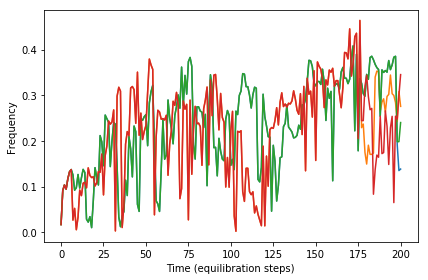

In [112]:
Nres=50
alpha = 4
T = 200
eps_fit = [0.01]
prob_fit = [1]
prob_strat = [1]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            present = generate_frequencies(Nres, alpha, T, i, prob_fit, prob_strat)
            plt.cla()
            for s in present:
                ax.plot(s.frequency, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
            ax.set_xlabel('Time (equilibration steps)')
            ax.set_ylabel('Frequency')
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            plt.tight_layout()
            plt.savefig('frequencies'+str(i)+'_2.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
            plt.show()

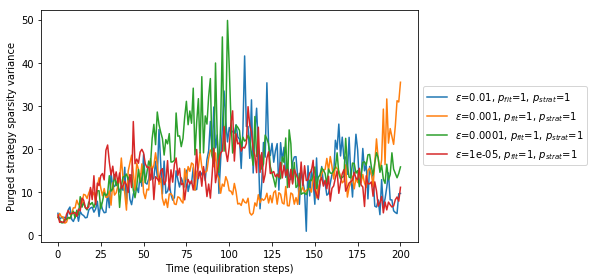

In [25]:
Nres=50
alpha = 4
T = 200
eps_fit = [0.01,0.001,0.0001, 0.00001]
prob_fit = [1]
prob_strat = [1]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            spar, var_spar, pur_spar, pur_var_spar = generate_sparsity_series(Nres, alpha, T, i, j, k)
            ax.plot(pur_var_spar, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Purged strategy sparsity variance')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('purged_var_sparsity.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

In [123]:
Nres=50
alpha = 4
T = 1
eps_fit = [0.00001]
prob_fit = [1]
prob_strat = [1]

#ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        nspec, present = generate_nspec_fitness(Nres, alpha, T, i, j)
        #ax.plot(nspec, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j))
#ax.set_xlabel('Time (equilibration steps)')
#ax.set_ylabel('# of distinct ecotypes')
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('fitness_evolution.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

#plt.show()

In [125]:
for s in present:
    if s.lineage==48:
        print s.norm_fit
        print s.strat_norm

1.00004687346
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.25  0.    0.
  0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.25  0.
  0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
1.00004665708
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.25  0.    0.
  0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.25  0.
  0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


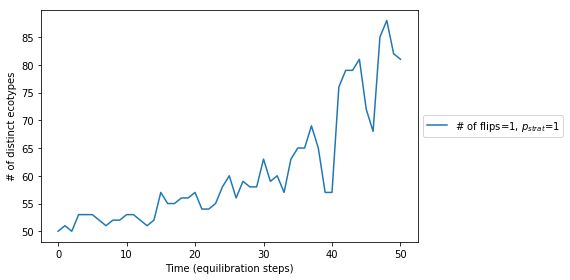

In [55]:
Nres=50
alpha = 4
T = 50
num_flips = [1]
prob_fit = [1]
prob_strat = [1]

ax = plt.subplot(111)

for i in num_flips:
    for j in prob_strat:
        nspec = generate_nspec_strategy(Nres, alpha, T, i, j)
        ax.plot(nspec, label='# of flips='+str(i)+', $p_{strat}$='+str(j))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('# of distinct ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('strategy_evolution2.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

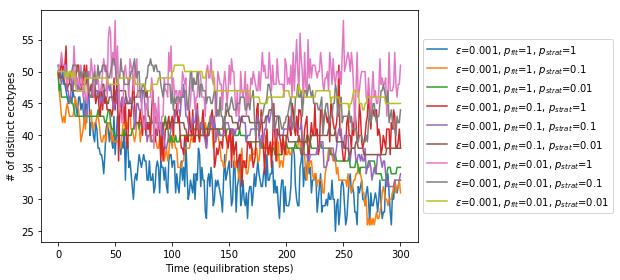

In [98]:
Nres=50
alpha = 4
T = 300
eps_fit = [0.001]
prob_fit = [1, 0.1, 0.01]
prob_strat = [1, 0.1, 0.01]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            vres, vh, present, fossil, nspec = generate_h_series(Nres, alpha, T, i, j, k)
            ax.plot(nspec, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('# of distinct ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('nspec_mut_var_sep_fit_strat.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()


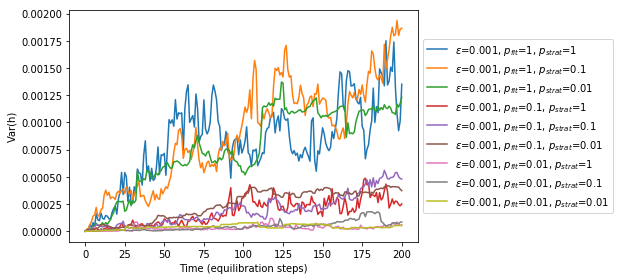

In [99]:
Nres=50
alpha = 4
T = 200
eps_fit = [0.001]
prob_fit = [1, 0.1, 0.01]
prob_strat = [1, 0.1, 0.01]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            varh = generate_var_h(Nres, alpha, T, i, j, k)
            ax.plot(varh, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Var(h)')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('varh_mut_var_sep_fit_strat.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

In [17]:
import collections
import matplotlib.mlab as mlab
import csv

Nres=50
alpha = 4
T = 300
eps_fit = [0.001]
prob_fit = [1, 0.1, 0.01]
prob_strat = [1, 0.1, 0.01]

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            freq = []
            for l in range(100):
                try:
                    vres, h, present, absent = generate_barcodes(Nres, alpha, T, i, j, k)
                    bcdf = pd.DataFrame([present[i].barcode for i in range(len(present))])
                    #print bcdf
                    tempfreq = []
                    for i in range(len(bcdf.columns)):
                        temp = bcdf[i].tolist()
                        counter = collections.Counter(temp)
                        tempfreq.extend(counter.values())
                    freq.append(tempfreq)
                except:
                    print "Iteration "+str(l)+" failed"
            with open("sfs"+str(i)+"_"+str(j)+"_"+str(k)+"_"+".csv", "wb") as f:
                writer = csv.writer(f)
                writer.writerows(freq)


    0    1    2    3    4    5    6    7    8    9   ...   291  292  293  294  \
0   182   99   48   69   35   69   84   84   42   72 ...    52   64   60   63   
1   182   99   48   69   35   69   84   84   42   72 ...    46   23   41   20   
2   182   99   48   69   35   69   84   84   42   72 ...     4    3   34   15   
3   182   99   48   69   35   69   84   84   42   72 ...    48   24    9    2   
4   118   83   87   43   24   62   35   19   13    8 ...    36   17   38   17   
5   118   83   87   43   24   62   35   19   13    8 ...    57   30   46   23   
6   182   99   48   69   35   69   84   84   42   72 ...    37   18   39   18   
7   182   99   48   69   35   69   84   84   42   72 ...    61   31   47   24   
8   182   99   48   69   35   69   84   84   42   72 ...    30   15    4   35   
9   182   99   48   69   35   69   84   84   42   72 ...     4    3    1    0   
10  182   99   48   69   35   69   84   84   42   72 ...    69   71   65   67   
11  182   99   48   69   35 

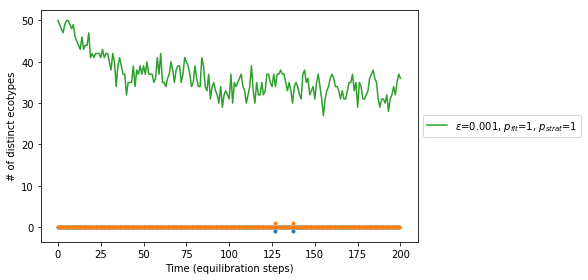

In [146]:
Nres=50
alpha = 4
T = 200
eps_fit = 0.001
prob_fit = 1
prob_strat = 1

ax = plt.subplot(111)


vres, vh, present, fossil, nspec = generate_h_series(Nres, alpha, T, eps_fit, prob_fit, prob_strat)
ax.plot(nspec, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('# of distinct ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('nspec_strat.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

In [425]:
import collections
import matplotlib.mlab as mlab

freq = []

for i in range(len(bcdf.columns)):
    temp = bcdf[i].tolist()
    counter = collections.Counter(temp)
    freq.extend(counter.values())

print len(freq)

1455


In [145]:
print nspec

[51, 48, 48, 49, 50, 48, 48, 47, 47, 46, 48, 47, 45, 42, 46, 48, 45, 47, 43, 44, 47, 42, 40, 44, 43, 44, 43, 43, 42, 41, 39, 42, 45, 39, 37, 42, 41, 40, 41, 40, 41, 41, 40, 38, 39, 39, 39, 40, 35, 36, 37, 34, 40, 38, 36, 40, 36, 38, 37, 41, 39, 38, 37, 37, 38, 42, 40, 41, 38, 34, 37, 39, 36, 35, 36, 36, 39, 36, 33, 36, 35, 33, 37, 35, 33, 36, 35, 35, 32, 28, 30, 30, 31, 35, 30, 31, 30, 29, 30, 32, 29, 30, 35, 35, 41, 37, 37, 38, 33, 33, 34, 33, 32, 31, 33, 37, 33, 37, 35, 30, 28, 30, 30, 35, 30, 29, 38, 33, 34, 34, 30, 28, 31, 32, 31, 33, 33, 31, 31, 31, 31, 36, 34, 35, 31, 34, 33, 33, 35, 32, 33, 33, 30, 32, 32, 32, 32, 31, 28, 28, 36, 35, 33, 33, 36, 33, 35, 35, 36, 34, 35, 35, 32, 34, 37, 36, 37, 36, 32, 36, 34, 30, 31, 33, 32, 33, 35, 38, 36, 33, 35, 36, 34, 34, 31, 31, 34, 31, 35, 35, 31]


In [70]:
print np.array(h)[0]

[ 0.96269394  1.01140612  1.00589921  1.01199689  1.04699391  0.97658853
  0.99956297  0.96487454  0.9350383   1.00138244  1.02015637  1.01753024
  1.00535791  0.9515975   1.01061212  0.95449988  1.04986128  1.00484263
  0.99578865  1.03867893  1.00756488  1.00392688  1.01033469  0.95574063
  0.98827649  0.9950201   1.01137455  1.08298835  1.05012644  0.96679337
  0.99976667  0.98981405  1.02951869  0.92027787  1.00207809  1.01937119
  0.97880108  0.96679906  0.9863122   0.96807446  0.99438648  1.009693
  1.0248827   1.02289357  1.01323754  0.96100799  0.99760629  1.0086
  1.03560619  1.00851771]


In [73]:
h = np.array(h)[0]
print len(h)

50


In [95]:
vres, h, present, absent = run_rand_env(50, 2)
print h
h = np.array(h)[0]
print h
m = calculate_frequencies(present, vres, h)

#print sum(m), sum(m2[0])
#print m, m2[0]

[[ 1.00224253  1.00028177  1.00281441  0.99869677  0.9989922   0.99979282
   0.99826936  1.00029209  0.99925437  0.99988701  0.99982565  1.00483848
   0.99982227  1.00139163  0.99721066  1.00265363  1.00035807  1.00009274
   0.99821126  0.99912162  0.99946094  1.00048797  0.99936432  1.00079123
   1.00231314  1.00135725  1.00094462  0.99766303  0.99854784  0.99868724
   0.99814452  0.99990847  0.99915752  1.00072919  1.00274857  1.00258637
   0.99853181  1.00341806  0.99827406  0.99997235  0.99815456  0.99861682
   0.99639493  0.99881327  1.00233886  1.00002119  0.99734816  0.99896862
   0.99955254  1.00169189]]
[ 1.00224253  1.00028177  1.00281441  0.99869677  0.9989922   0.99979282
  0.99826936  1.00029209  0.99925437  0.99988701  0.99982565  1.00483848
  0.99982227  1.00139163  0.99721066  1.00265363  1.00035807  1.00009274
  0.99821126  0.99912162  0.99946094  1.00048797  0.99936432  1.00079123
  1.00231314  1.00135725  1.00094462  0.99766303  0.99854784  0.99868724
  0.99814452  0

In [81]:
a = np.array([present[i].norm_fit*present[i].strat_norm for i in range(len(present))])
print len(a[0])

50


In [84]:
print np.exp(np.random.normal(0, 0.001))

0.999061754064
